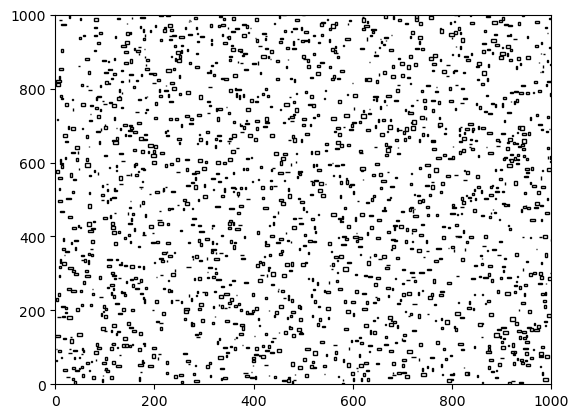

In [18]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
# create 1000 random rectangles in the space of 0-1000
x_lim = [0, 1000]
y_lim = [0, 1000]
w_lim = [1, 10]
h_lim = [1, 10]

# check each rect for intersection with the others
num = 2000
rects = []
def check_for_intersection(rect, rects):
    for i in range(rects.__len__()):
        if rect[0] < rects[i][0] + rects[i][2] and rect[0] + rect[2] > rects[i][0] and rect[1] < rects[i][1] + rects[i][3] and rect[1] + rect[3] > rects[i][1]:
            return True
    return False

for i in range(num):
    x = np.random.randint(x_lim[0], x_lim[1])
    y = np.random.randint(y_lim[0], y_lim[1])
    w = np.random.randint(w_lim[0], w_lim[1])
    h = np.random.randint(h_lim[0], h_lim[1])
    rect = np.array([x, y, w, h])
    if not check_for_intersection(rect, rects):
        rects.append(rect)

# plot them
fig, ax = plt.subplots()
for rect in rects:
    ax.add_patch(Rectangle((rect[0], rect[1]), rect[2], rect[3], fill=False))
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.show()
    
# make last element of rects from deg to rad
rects = np.array(rects)
for i in range(rects.__len__()):
    rects[i][3] = np.deg2rad(rects[i][3])
    

    

(100, 2)


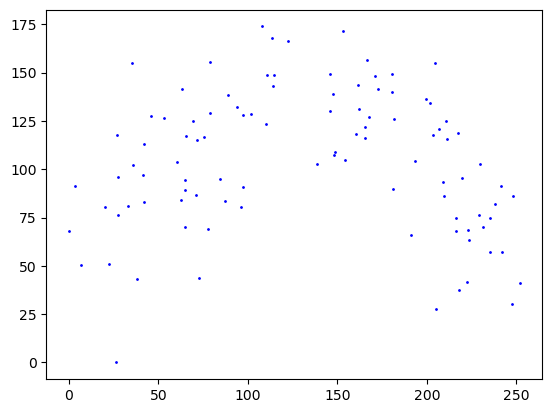

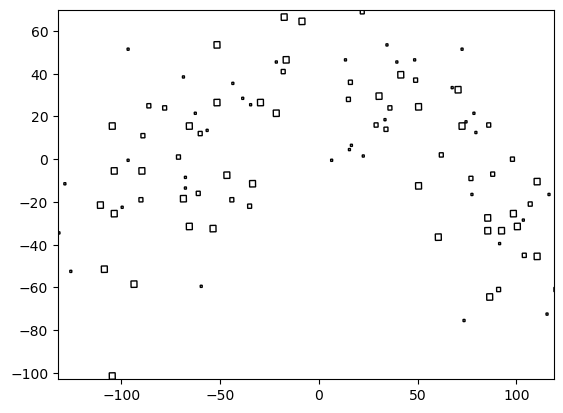

(99, 4)


In [19]:
import sklearn
from sklearn.datasets import make_moons

# Define limits
x_lim = [0, 300]
y_lim = [0, 300]
w_lim = [1,4 ]
theta_lim = [1, 2]
num = 100
# create moons
X, y = make_moons(n_samples=2*num, noise=0.2, random_state=0)
# take only 1 of the moons
X = X[y == 0]
x_min = X[:,0].min()
y_min = X[:,1].min()
X[:,0] -= (x_min)
X[:,1] -= (y_min)
# get them to the same scale
X *= x_lim[1]/3
plt.scatter(X[:,0], X[:,1], s=1, c='b')
moon = X
print(moon.shape)
# create 1000 squares
# check each rect for intersection with the others
squares = []
def check_for_intersection(square, squares):
    for i in range(squares.__len__()):
        if square[0] < squares[i][0] + squares[i][2] and square[0] + square[2] > squares[i][0] and square[1] < squares[i][1] + squares[i][2] and square[1] + square[2] > squares[i][1]:
            return True
    return False
random = False
if random:
    for i in range(num-1):
        x = np.random.randint(x_lim[0], x_lim[1])
        y = np.random.randint(y_lim[0], y_lim[1])
        w = np.random.randint(w_lim[0], w_lim[1])
        theta = np.random.randint(theta_lim[0], theta_lim[1])
        square = np.array([x, y, w, theta])
        if not check_for_intersection(square, squares):
            squares.append(square)
# instead of random, create a half moon of squares
if not random:
    for i in range(num-1):
        # moon is 1000x1000. at each point put a square
        x = int(moon[i][0])
        y = int(moon[i][1])
        w = np.random.randint(w_lim[0], w_lim[1])
        theta = np.random.randint(theta_lim[0], theta_lim[1])
        square = np.array([x, y, w, theta])
        if not check_for_intersection(square, squares):
            squares.append(square)

squares = np.array(squares)
# normalize mean to be 0,0
x_mean = squares[:,0].mean().astype(int)
y_mean = squares[:,1].mean().astype(int)
squares[:,0] -= x_mean
squares[:,1] -= y_mean
x_lim = [squares[:,0].min(), squares[:,0].max()]
y_lim = [squares[:,1].min(), squares[:,1].max()]
    
# plot them
fig, ax = plt.subplots()
for square in squares:
    ax.add_patch(Rectangle((square[0], square[1]), square[2], square[2], angle=square[3], fill=False))
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.show()

# 
print(squares.shape)
# make last element of squares from deg to rad
squares[:, 3] = np.deg2rad(squares[:, 3])

In [24]:
# lets view kmeans as a latent variable model where z is one-hot descrete latent variable
from torch.distributions.dirichlet import Dirichlet
from torch.nn.functional import one_hot
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

class LVKmeans(nn.Module):
    def __init__(self, n_centroids, output_dim, latent_size=400):
        super(LVKmeans, self).__init__()
        self.n_centroids = n_centroids
        self.output_dim = output_dim
        self.latent_size = latent_size
        # decoder is a linear layer
        #output_dim = n_centroids
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, output_dim, bias=False),
        )
        # init z to one-hot descrete latent variable
        self.z = nn.Parameter(
            Dirichlet(torch.ones(n_centroids)).sample((latent_size,)).T
            , requires_grad=True
        )
        self.projector = nn.Sequential(
            nn.Linear(n_centroids, n_centroids *10),
            nn.ReLU(),
            nn.Linear(n_centroids *10, n_centroids *100),
            nn.ReLU(),
            nn.Linear(n_centroids *100, n_centroids *10),
            nn.ReLU(),
            nn.Linear(n_centroids *10, n_centroids),
        )
        self.z_l = None
        self.z_l_fuzzy = None
            
        
    def col_one_hot(self, z):
        # one hot encoding
        #z = torch.argmax(z, dim=0)
        z = torch.argmin(z, dim=0)
        z = one_hot(z, num_classes=self.n_centroids).T
        if self.n_centroids == self.latent_size:
            # make z eye matrix
            z = torch.eye(self.n_centroids)

        return z.float()
    
    def get_z(self):
        return self.z
    
    # sample z from without one-hot encoding
    def sample_z(self, regularize=False):
        if regularize:
            z = self.z
        else:
            z = torch.bernoulli(self.z)
        y = self.decoder(z)
        return y, z

    def forward(self, z):
        z = self.col_one_hot(z)
        # make z dtype float
        y = self.decoder(z)
        self.z_l = y
        # make y fuzzy
        y = y + torch.randn(y.shape)* 1
        self.z_l_fuzzy = y
        y = self.projector(y.T).T
        return y
sq, qp = loadData(100)
sq = torch.from_numpy(sq).float()
sq = squares
# =============================================================================
n_centroids = 4
output_dim = 2
latent_size = 400
model = LVKmeans(n_centroids, output_dim, latent_size=latent_size)
#from ebmUtils import *

# criterion
from src.metrics import Linf_simple
from src.ebmUtils import loss_functional
criterion = Linf_simple
# optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
c2 = nn.MSELoss()
# epochs
epochs = 100
times = 1
p_times = epochs / times
# create times * figures
col = 4
row = int(times / col) + 1
#fig, axs = plt.subplots(row, col, figsize=(10, 10))
# y = torch.tensor(spiral_data, dtype=torch.float32)
y = sq
# input =torch.from_numpy(spiral_data).float()
input = sq
costs = []
best_model = None
best_cost = float('inf')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
costs = []
rem = []
reg = []
rem.append(torch.tensor(1))
p_c = []
p_p = []
p_e = []
reg_let_r = []
reg_cost_r = []
models = []
test = False
z_l =[]
z_l_fuzzy = []
c_l = []
c_l_fuzzy = []
std = []
mu =[]
for epoch in range(epochs):

    # forward
    outputs = model(model.z)

    # add random noise
    c_l.append(outputs)
    if epoch %1000 == 0:
        scale = 100
        std_ = rem[-1].item()/scale
        outputs = outputs + torch.randn_like(outputs)*std_
        std.append(std_)
        mu.append(outputs)
    # calculate cost
    c_l_fuzzy.append(outputs)
    # make outputs numpy
    cost = loss_functional(outputs, y, model)
    c1 = cost
    F, z = cost.min(1)
    rem.append(torch.sum(F))
    cost = torch.mean(F) 
    #cost = torch.sum(F) + reg_cost + reg_let
    if test == True and epoch > 100000:
        cost = c2_cost + reg_cost + reg_let + c3_cost
    reg.append(0)
    # append latents
    z_l.append(model.z_l)
    z_l_fuzzy.append(model.z_l_fuzzy)
    # backward
    optimizer.zero_grad()
    # make sure cost is torch tensor
    costs.append(cost.item())
    #rem.append(cost)
    cost.backward()
    optimizer.step()
    if cost < best_cost:
        best_cost = cost
        best_model = model
        best_outputs = outputs
        best_z = z
        best_lat = model.z_l
        best_epoch = epoch
    if cost < 6000:
        p_p.append(outputs)
        p_c.append(cost)
        p_e.append(epoch)
    # print
    if (epoch + 1) % p_times == 0:
        # print
        print('Epoch [{}/{}], Cost: {:.4f}'.format(epoch + 1, epochs, cost.item()))
        print('Outputs: ', outputs)
# plot outputs
outputs = best_outputs.detach().numpy()
# plot
fig, ax = plt.subplots()
ax.scatter(outputs[:, 0], outputs[:, 1], s=1, c='b')
# plot outputs
ax.scatter(y[:, 0], y[:, 1], s=1, c='r')
# add a plot for costs
fig, ax = plt.subplots()
ax.plot(costs)
plt.show()


print('Best epoch: ', best_epoch)
print('Best cost: ', best_cost)

Loading data...
Data loaded.


RuntimeError: expected scalar type Double but found Float

array([[  77,  -17,    1,    0],
       [-106, -103,    3,    0],
       [  97,  -27,    3,    0],
       [  84,  -29,    3,    0],
       [ -35,  -13,    3,    0],
       [ -79,   23,    2,    0],
       [ 103,  -46,    2,    0],
       [  69,   31,    3,    0],
       [  28,   15,    2,    0],
       [ -97,   51,    1,    0],
       [  40,   38,    3,    0],
       [ -10,   63,    3,    0],
       [   6,   -1,    1,    0],
       [  97,   -1,    2,    0],
       [ -36,  -23,    2,    0],
       [  79,   12,    1,    0],
       [  90,  -62,    2,    0],
       [ -72,    0,    2,    0],
       [ -23,   20,    3,    0],
       [  61,    1,    2,    0],
       [ -22,   45,    1,    0],
       [ 119,  -62,    2,    0],
       [ -68,   -9,    1,    0],
       [ -87,   24,    2,    0],
       [ -60,  -60,    1,    0],
       [  87,   -8,    2,    0],
       [  49,  -14,    3,    0],
       [  14,   27,    2,    0],
       [ -19,   40,    2,    0],
       [-105,  -27,    3,    0],
       [ 1

In [27]:
loss_functional(best_outputs, data, best_model)

RuntimeError: expected scalar type Double but found Float

Loading data...
Data loaded.

Creating student for node 0 that has 99 data, which is more than the threshold 90.
Bounding box for node 0: [[-138, 125], [-109, 76]]
Creating teacher for node 0 with 4 centroids.
Training Teacher Model
Epoch: 20/200.. 
 Training loss: 51.50094.. 
 torch.mean(F): 51.50094.. 
 Reg Proj: 0.00000.. 
 Reg Latent: 0.00000.. 
 Repulsive: 0.00000.. 
 Memory: 0.51501.. 
 Output: 
 [[-34.52418   -53.855244 ]
 [-62.727314  -97.79492  ]
 [ 36.86934    57.97329  ]
 [  2.011402    1.9431279]]
Epoch: 40/200.. 
 Training loss: 37.90646.. 
 torch.mean(F): 37.90646.. 
 Reg Proj: 0.00000.. 
 Reg Latent: 0.00000.. 
 Repulsive: 0.00000.. 
 Memory: 0.37906.. 
 Output: 
 [[ -54.01114   -21.857044]
 [-115.965836  -55.239647]
 [  94.658615   45.395424]
 [  43.41173    19.431263]]
Epoch: 60/200.. 
 Training loss: 33.62860.. 
 torch.mean(F): 33.62860.. 
 Reg Proj: 0.00000.. 
 Reg Latent: 0.00000.. 
 Repulsive: 0.00000.. 
 Memory: 0.33629.. 
 Output: 
 [[-19.399897    5.2967687]
 [-

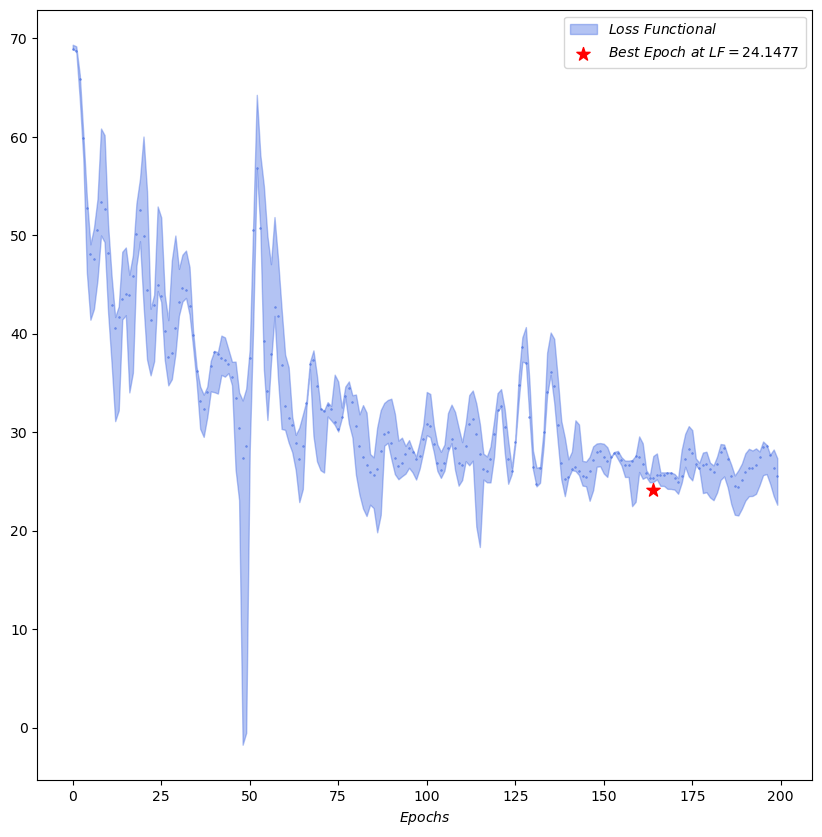

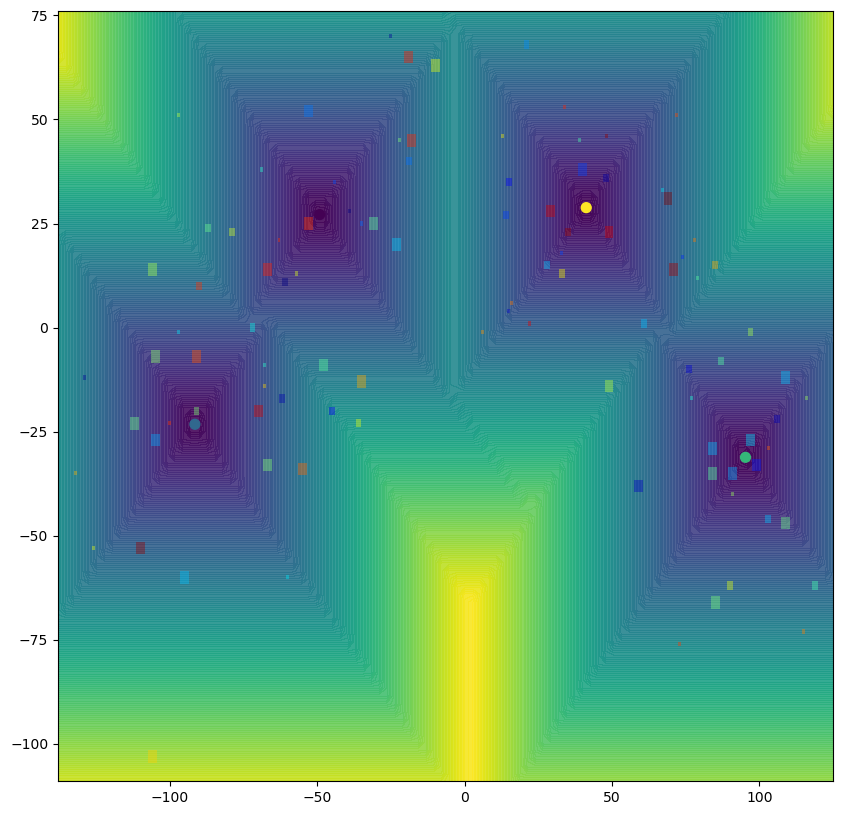

getUncertaintyArea
Ouputs are [[-49.1951    27.151005]
 [-91.53107  -23.227825]
 [ 95.309814 -31.161976]
 [ 41.26529   28.8218  ]]
scale is 263
Processing...
flag is 214
m is 187
i is 400


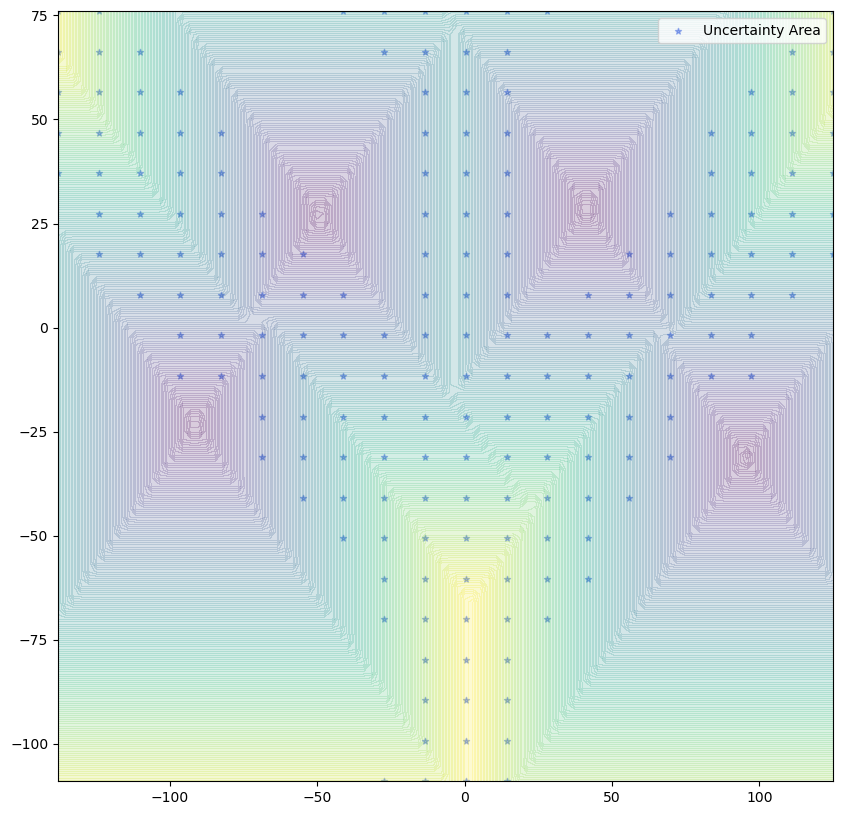

Labeled 0/187 points.
Labeled all 187/187 points.


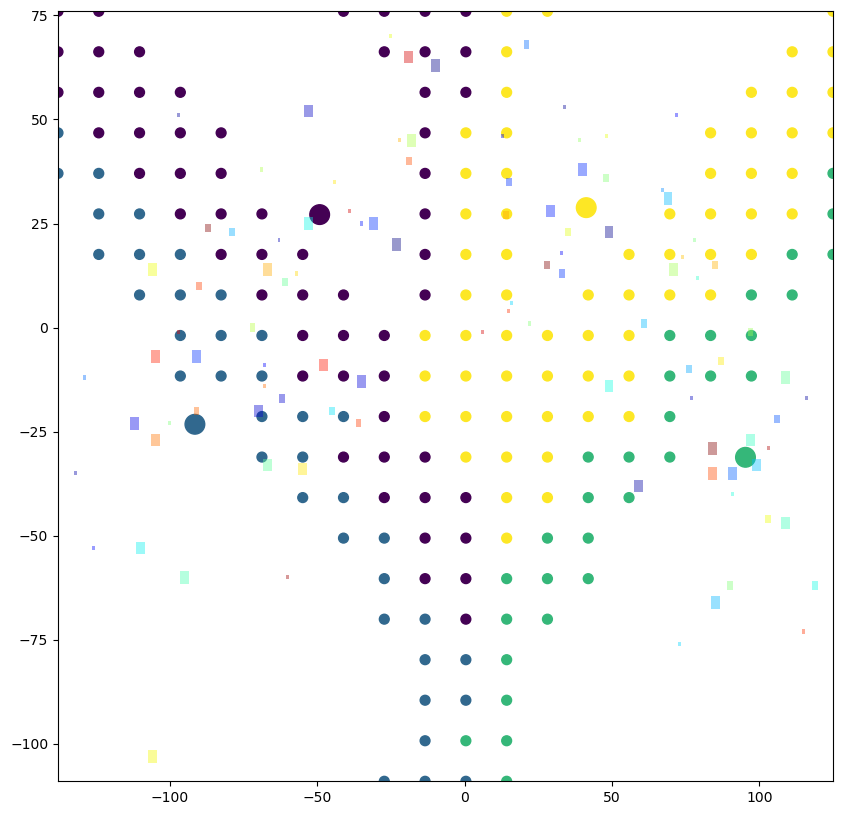

Training Student Model
Acc:  0.3582887700534759
Epoch:  0 Cost:  157.044921875
Acc:  0.9786096256684492
Epoch:  200 Cost:  9.496387481689453
Acc:  0.9946524064171123
Epoch:  400 Cost:  3.6169703006744385
Acc:  0.9786096256684492
Epoch:  600 Cost:  7.438161373138428
Acc:  0.9946524064171123
Epoch:  800 Cost:  1.5768028497695923
Acc:  0.9946524064171123
Epoch:  1000 Cost:  1.0325918197631836
Acc:  0.983957219251337
Epoch:  1200 Cost:  5.651472091674805
Acc:  0.9946524064171123
Epoch:  1400 Cost:  1.8563034534454346
Acc:  0.9946524064171123
Epoch:  1600 Cost:  1.203870415687561
Acc:  0.9679144385026738
Epoch:  1800 Cost:  10.190450668334961
Saved student config to models/squares/100/class0_student_config.pt
Saved teacher training results to models/squares/100/class0_student_training_results.npy


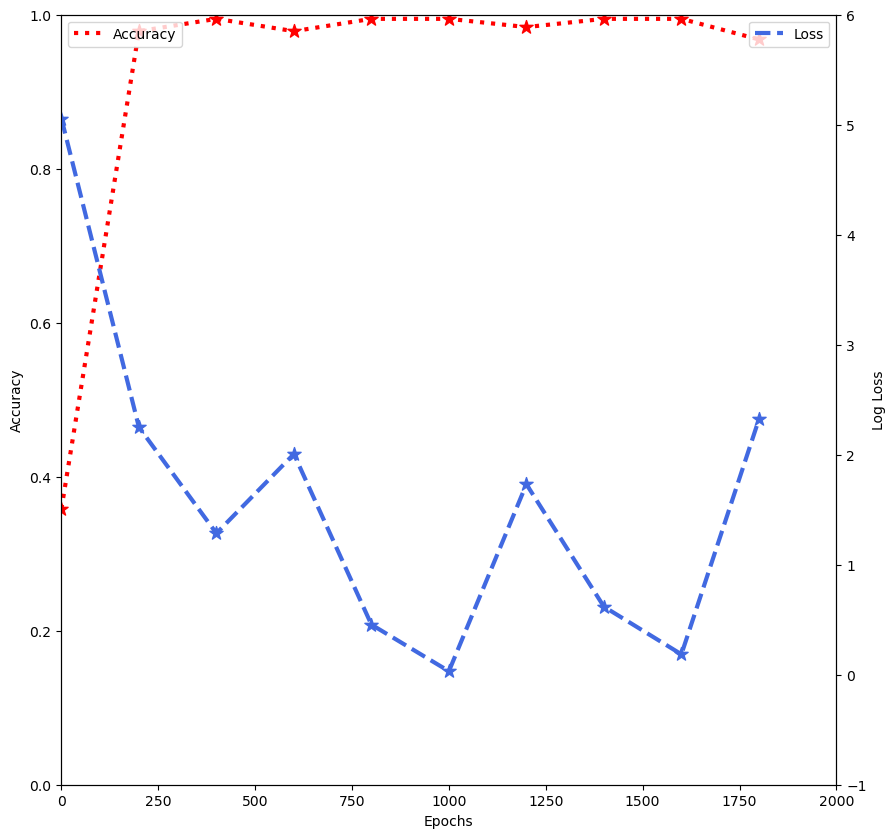

In [23]:
import torch
from src.k_tree import Ktree
from src.utils.data import loadData

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
data, _ = loadData(100)
data = squares


#data = rects
learning_rate = 5e-3 # 1e-2, 5e-3
k = 4
teacher_args = {
    "optimizer_lr": learning_rate,
    "epochs": 200, # 300
    "times": 10,
    "alpha": 0, # 5 , 10
    "beta": 0, # 5
    "gamma": 0,
    "delta": 0.1,
    "f_clk": 20,
    "scale": 1,
    "number_of_centroids": k,
    "latent_size": 400,
    "encoder_activation": False,
    "encoder_depth": 3,
    "predictor_width": k*100,
    "predictor_depth": 3,
}
n = 20
un_args = {
    "N": n,
    "M": n**2-1, # 10000 - 1
    "epsilon": 0.14 # here a layer value should be somehow included. As layers get denser  epilson should be smaller
}
student_args = {
    "optimizer_lr": 5e-3,
    "epochs": 2000, # 30000, 2000
    "width": 200,
    "depth": 5,
}

stop_criterion = 0.1*k*len(data) if len(data) > 500 else 100
thresshold = 90
ktree = Ktree(thresshold, data, teacher_args, un_args, student_args)
ktree.create_tree(save_path_prefix="models/squares/100/class", plot=True)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
acc = 0
mean_acc = 0
times=0
print_flag = False
random = True
out_of_dist = False 
out_of_manifold = False
ball =  2000
x_lim = min(data[:,0]), max(data[:,0])
y_lim = min(data[:,1]), max(data[:,1])
while times < 1:
    # now lets create randomly N points in the space 0-300, 0-300
    # [[-6, 257], [-6, 179]]
    n = 10**2
   
    if random:
        random_p = torch.zeros(n, 2)
        for i in range(n):
            random_p[i] = torch.Tensor([np.random.randint(x_lim[0],x_lim[1]), np.random.randint(y_lim[0],y_lim[1])])
        infer_points = random_p.to(device)
    else:
        nop =  n
        random_p = torch.zeros(nop, 2)
        #x_lim = [0,300]
        #y_lim = [0,300]
        num = int(np.sqrt(nop))
        for i, x in enumerate(np.linspace(x_lim[0],x_lim[1], num)):
            for j, y in enumerate(np.linspace(y_lim[0],y_lim[1], num)):
                random_p[i*num+j] = torch.Tensor([x, y])

        infer_points = random_p.to(device)
        print(infer_points.shape)
        plt.scatter(infer_points[:,0], infer_points[:,1])

    if out_of_dist and out_of_manifold:
        # plot points outside 0,300
        x_lim = [0,300]
        y_lim = [0,300]
        x_lim = [x_lim[0]-ball, x_lim[1]+ball]
        y_lim = [y_lim[0]-ball, y_lim[1]+ball]
        num = int(np.sqrt(nop))
        for i, x in enumerate(np.linspace(x_lim[0],x_lim[1], num)):
            for j, y in enumerate(np.linspace(y_lim[0],y_lim[1], num)):
                random_p[i*num+j] = torch.Tensor([x, y])
        infer_points = random_p.to(device)
        print(infer_points.shape)
        plt.scatter(infer_points[:,0], infer_points[:,1])
    num_of_correct_predictions = 0
    qp = infer_points
    z_wrong = np.zeros(len(qp))
    z_label_wrong = np.zeros(len(qp))
    for i in range(len(qp)):
        query_point = qp[i]
        query_point = torch.Tensor(query_point)
        pred = ktree.query(query_point)
        brute_force = ktree.root.query(query_point)
        # print(pred)
        # print(brute_force)
        if(np.array_equal(pred, brute_force)):
            num_of_correct_predictions += 1
        else:
            z_wrong[i] = max(abs(pred[:2]-brute_force[:2]))
            if z_wrong[i] > 0.1:
                z_label_wrong[i] = 1

            if print_flag:
                print("="*20)
                print(f"Wrong prediction for {query_point}")
                print(f"Predicted {pred}")
                print(f"Brute force {brute_force}")
                # reshape z_wong to be a 2d array
    axis = int(np.sqrt(len(qp)))
    # make contour of the z_wrong
    x = np.linspace(x_lim[0],x_lim[1], axis)                                        
    y = np.linspace(y_lim[0],y_lim[1], axis)
    X, Y = np.meshgrid(x, y)
    Z = z_wrong.reshape(X.shape)
    if out_of_dist and out_of_manifold:
        # make 0 in Z all values between 0,300, 0,300
        # first find index in X 
        x_index = np.where((X>=x_lim[0]+ball) & (X<= x_lim[1]-ball))
        # now make Z 0 in these indexes
        Z[x_index] = 0
        
    # make 3d plot
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.contourf(X, Y, Z, 200, cmap='viridis')
    # rotate
    ax.view_init(45, 30)
    acc = num_of_correct_predictions / len(infer_points) * 100
    mean_acc += acc
    times += 1

    print(f"The percentage of correct predictions is {acc:.2f}%")

print(f"The best percentage of correct predictions is {acc:.2f}%")
print(f"The mean percentage of correct predictions is {mean_acc/times:.2f}%")

In [ ]:
label

In [ ]:
# do a 2d contour
fig, ax = plt.subplots()
for i, x in enumerate(np.linspace(x_lim[0],x_lim[1], axis)):
    for j, y in enumerate(np.linspace(y_lim[0],y_lim[1], axis)):
        random_p[i*axis+j] = torch.Tensor([x, y])
infer_points = random_p.to(device)
y = np.linspace(y_lim[0],y_lim[1], axis)
x = np.linspace(x_lim[0],x_lim[1], axis)
label = ktree.root.student(qp).max(1)[-1].detach().cpu().numpy()
Z_ = label.reshape(X.shape)
#plt.contourf(X, Y, Z_, 100, cmap='viridis')
ax.contourf(X, Y, Z_, 100, cmap='viridis')
# make color bar of Z_
# plot a scatter of wrong predictions
# make new label
ax.scatter(qp[:,0], qp[:,1], c=z_label_wrong, cmap='bwr')
#plt.colorbar()
# do a plot of the area [0,300]
# plot a square centered at 0,0 with length 300
ax.plot([0,0], [0,300], color='r')
ax.plot([0,300], [0,0], color='r')
ax.plot([0,300], [300,300], color='r')
ax.plot([300,300], [0,300], color='r')
# plot them

#for square in squares:
#    ax.add_patch(Rectangle((square[0], square[1]), square[2], square[2], angle=np.deg2rad(square[3]), fill=False))
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.show()


#plt.show()

In [ ]:
x1 = np.array([77, 69])
x2 = np.array([251, 41])
q = np.array([1178.9474, -757.8947])
d1 = max(abs(x1-q))
d2 = max(abs(x2-q))
d3 = max(abs(x1-x2))
print(d1)
print(d2)
print(d3)
print(d2== d1-d3)

In [ ]:
X[1].shap

In [ ]:
num_of_correct_predictions = 0
qp = infer_points
z =  np.zeros(len(qp))
for i in range(len(qp)):
    query_point = qp[i]
    pred = ktree.query(query_point)
    brute_force = ktree.root.query(query_point)
    # print(pred)
    # print(brute_force)
    if(np.array_equal(pred, brute_force)):
        num_of_correct_predictions += 1
    else:
        # do l-inf norm
        z[i] = max(abs(pred[:2]-brute_force[:2]))
print(z)
 
print(f"The percentage of correct predictions is {(num_of_correct_predictions / len(infer_points)) * 100:.2f}%")


In [ ]:
print(pred)
print(brute_force)

In [ ]:
plt.scatter(infer_points[:,0], infer_points[:,1], c=z)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

nop =  2000
random_p = torch.zeros(nop, 2)
x_lim = [0,300]
y_lim = [0,300]
# add e
e = 0
x_lim = [x_lim[0]-e, x_lim[1]+e]
y_lim = [y_lim[0]-e, y_lim[1]+e]
num = int(np.sqrt(nop))
random_p = torch.zeros(num*num, 2)
for i, x in enumerate(np.linspace(x_lim[0],x_lim[1], num)):
    for j, y in enumerate(np.linspace(y_lim[0],y_lim[1], num)):
        random_p[i*num+j] = torch.Tensor([x, y])
 
infer_points = random_p.to(device)
plt.scatter(infer_points[:,0], infer_points[:,1])
print(infer_points.shape)

In [ ]:
def R(z, node, infer_points):
    for i in range(len(node.children)):
        if not node.children[i].isLeaf():
            index = z == node.children[i].student(infer_points).max(1)[1]
            qp = infer_points[index]
            z_new = node.children[i].student(qp).max(1)[1]
            max_z = z.max()
            z[index] = max_z + 1 + z_new
            for j in range(len(node.children[i].children)):
                R(z, node.children[i].children[j], qp)
        else:
            if node.parent is not None:
                R(z, node.parent, infer_points)

# Initial prediction
z = ktree.root.student(infer_points).max(1)[1]

# Update z recursively
R(z, ktree.root, infer_points)

# Plot infer_points with colors based on z
plt.scatter(infer_points[:,0], infer_points[:,1], c=z)
plt.show()

In [ ]:
infer_points
z = ktree.root.student(infer_points).max(1)[1]
def R(z, node, infer_points):
    for i in range(len(node.children)):
        if not node.children[i].isLeaf():
            if z in node.children[i].student(infer_points).max(1)[1]:
                index = z == node.children[i].student(infer_points).max(1)[1]
                qp = infer_points[index]
                z_new = node.children[i].student(qp).max(1)[1]
                max_z = z.max()
                z[index] = max_z+ 1 + z_new
                length = len(node.children[i].children)
                for j in range(length):
                    R(z, node.children[i].children[j], infer_points)
        else:
            node = node.parent
            R(z, node, infer_points)
                
R(z, ktree.root, infer_points)
# plot infer points, color coded by the prediction
print(z.max())
plt.scatter(infer_points[:,0], infer_points[:,1], c=z)

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def traverse_and_update(node, infer_points, z, k=3):
    if node.isLeaf():
        return z

    for i in range(k):
        node_flag = node.children[i].isLeaf()
        qp = infer_points[z==i]
        if not node_flag:
            pred = node.children[i].student(qp)
            _, z_ = torch.max(pred, 1)
            max_z = torch.max(z)
            index = z==i
            z[index] = (i+1)*max_z + z_ + 1
            for j in range(k):
                node_flag = node.children[i].children[j].isLeaf()
                qp = infer_points
                if not node_flag:
                    qp = infer_points[index]
                    pred = node.children[i].children[j].student(qp)
                    _, z__ = torch.max(pred, 1)
                    z[index] = (j+1)*max_z + z__ + 1
                    z = traverse_and_update(node.children[i].children[j], qp, z, k)
    return z

def plot_contour(infer_points, z, e=0, num=100):
    x = np.linspace(0-e, 300+e, num)
    y = np.linspace(0-e, 300+e, num)
    X, Y = np.meshgrid(x, y)
    z_new = z
    Z = z_new.reshape(X.shape)
    plt.contour(Y,X, Z, cmap='viridis',levels=200, alpha=0.8)
    plt.show()

# Initial prediction
node = ktree.root
n = infer_points.shape[0]
z = torch.zeros(1, n)
pred = node.student(infer_points)
_, z = torch.max(pred, 1)

# Update z recursively
z = traverse_and_update(node, infer_points, z)

# Plot infer_points with colors based on z
plot_contour(infer_points, z, e=0, num=int(np.sqrt(n)))



In [ ]:
node = ktree.root
# z are the labels shape (1,N)
n = infer_points.shape[0]
z = torch.zeros(1, n)
print(node.isLeaf())
pred = node.student(infer_points)
_, z = torch.max(pred, 1)
print(z.shape)
# ======================
k=3
for i in range(k):
    node_flag = node.children[i].isLeaf()
    qp = infer_points[z==i]
    if not node_flag:
        pred = node.children[i].student(qp)
        _, z_ = torch.max(pred, 1)
        max_z = torch.max(z)
        #print(max_z)
        index = z==i
        z[index] = (i+1)*max_z + z_ + 1
        #print(torch.max(z))
        for j in range(k):
            node_flag = node.children[i].children[j].isLeaf()
            qp = infer_points
            if not node_flag:
                print("not leaf")
                qp = infer_points[index]
                pred = node.children[i].children[j].student(qp)
                _, z__ = torch.max(pred, 1)
                max_z_ = torch.max(z)
                print(z__.shape)
               
                index_ = z[index] == (i+1)*max_z + j + 1
                #index_ = z[z[index]==(i+1)*max_z + z_ + 1] == j
                z[index] = (j+1)*max_z + z__ + 1
# do a contour plot of the predictions 
x = np.linspace(0-e, 300+e, num)
y = np.linspace(0-e, 300+e, num)
X, Y = np.meshgrid(x, y)
z_new = z
Z = z_new.reshape(X.shape)
plt.contour(Y,X, Z, cmap='viridis',levels=200, alpha=0.8)
# also plot the centroids
#plt.scatter(qp[:,0], qp[:,1], c=z_, s=10)

##  Tree search

In [ ]:
x = torch.tensor([1.,2.,3.,6.])
y = torch.tensor(2., dtype=torch.long)
ce = torch.nn.CrossEntropyLoss()
ce(x, y)

In [ ]:
class Critic(nn.Module):
    """
        Critic Network

        Parameters:
            input_dim (int): Number of input dimensions
            hidden_dim (int): Number of hidden dimensions
            output_dim (int): Number of output dimensions
            
        Returns:
            output: Critic network output
        
        Methods:
            forward(state): Returns critic network output for given state
    """
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, state):
        x = self.relu(self.fc1(state))
        x = self.fc2(x)
        return x

class Actor(nn.Module):
    """
        Actor Network
        
        Parameters:
            input_dim (int): Number of input dimensions
            hidden_dim (int): Number of hidden dimensions
            output_dim (int): Number of output dimensions
            
        Returns:
            output: Actor network output
            
        Methods:
            forward(state): Returns actor network output for given state
    """
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, state):
        x = self.relu(self.fc1(state))
        x = self.softmax(self.fc2(x))
        return x

class ActorCritic(nn.Module):
    """
        Actor Critic Network
        
        Parameters:
            input_dim (int): Number of input dimensions
            hidden_dim (int): Number of hidden dimensions
            output_dim (int): Number of output dimensions
            
        Returns:
            policy: Actor network output
            value: Critic network output
            
        Methods:
            forward(state): Returns actor and critic network output for given state
    """
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ActorCritic, self).__init__()
        self.actor = Actor(input_dim, hidden_dim, output_dim)
        self.critic = Critic(input_dim, hidden_dim, 1)

    def forward(self, state):
        policy = self.actor(state)
        value = self.critic(state)
        return policy, value

In [ ]:
class A2C:
    """
        A2C Agent
        
        Parameters:
            actor_critic (ActorCritic): ActorCritic network
            optimizer (torch.optim): PyTorch optimizer
            gamma (float): Discount factor
            
        Methods:
            update(state, action, reward, next_state, done): Performs a single agent update
    """
    def __init__(self, actor_critic, optimizer, gamma=0.99):
        self.actor_critic = actor_critic # ActorCritic
        self.optimizer = optimizer # torch.optim
        self.gamma = gamma # float: discount factor

    def update(self, state, action, reward, next_state, done):
        # Get current policy and value
        policy, value = self.actor_critic(state)

        # Compute target value
        _, next_value = self.actor_critic(next_state)
        target_value = reward + self.gamma * next_value * (1 - done)

        # Compute advantage
        advantage = target_value - value

        # Compute actor loss (policy gradient loss)
        action_prob = policy.gather(1, action.unsqueeze(-1)).squeeze(-1)
        actor_loss = -torch.log(action_prob + 1e-5) * advantage.detach()

        # Compute critic loss (value loss)
        critic_loss = F.mse_loss(value, target_value.detach())

        # Combine losses
        loss = actor_loss + critic_loss

        # Perform backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return actor_loss.item(), critic_loss.item()

In [ ]:
# Define environment
env = ...  # your environment

# Define actor-critic network
input_dim = ...  # your input dimension
hidden_dim = ...  # your hidden dimension
output_dim = ...  # your output dimension
actor_critic = ActorCritic(input_dim, hidden_dim, output_dim)

# Define optimizer
optimizer = torch.optim.Adam(actor_critic.parameters())

# Define A2C module
a2c = A2C(actor_critic, optimizer)

# Define episodes
num_episodes = 1000 # number of episodes
max_steps = 100 # steps per episode

# Training loop
for episode in range(num_episodes):
    state = env.reset() # reset environment: returns initial state
    for t in range(max_steps):
        # Select action
        policy, _ = actor_critic(state)
        action = torch.multinomial(policy, 1) # sample action from policy

        # Take step in environment
        next_state, reward, done, _ = env.step(action.item())

        # Update actor-critic
        actor_loss, critic_loss = a2c.update(state, action, reward, next_state, done)

        # Update state
        state = next_state

        # Break if done
        if done:
            break

In [ ]:
# Define environment
env = ...  # your environment

# Load actor-critic network
actor_critic = ...  # load your trained actor-critic network

# Define episodes
num_episodes = 10  # number of episodes to run

# Inference loop
for episode in range(num_episodes):
    state = env.reset()  # reset environment: returns initial state
    done = False
    while not done:
        # Select action
        with torch.no_grad():
            policy, _ = actor_critic(state)
            action = torch.multinomial(policy, 1)  # sample action from policy

        # Take step in environment
        next_state, reward, done, _ = env.step(action.item())

        # Update state
        state = next_state

        # Render environment
        env.render()

        # Break if done
        if done:
            break